# CS579: Lecture 05  
** Community Detection **

*[Dr. Aron Culotta](http://cs.iit.edu/~culotta)*  
*[Illinois Institute of Technology](http://iit.edu)*

(Many figures come from [Mining of Massive Datasets](http://www.mmds.org/), Jure Leskovec, Anand Rajaraman, Jeff Ullman)

![network](network.png)

**Betweenness:** The betweenness of an edge $(A, B)$ is the fraction of shortest paths between any nodex $X$ and $Y$ that include edge $(A, B)$.

High betweenness $\rightarrow$ $A$ and $B$ belong in different communities.

![network](network.png)

What is **betweenness** of $(B,D)$?

Of $(D,F)$?

![network](network.png)

What is **betweenness** of $(B,D)$? 

> $(B,D)$ is on all shortest paths connecting any of $\{A,B,C\}$ to any of $\{D,E,F,G\}$.

> Thus, betweenness is $3 * 4 = \mathbf{12}.$

Of $(D,F)$?

> $(D,F)$ is on shortest paths from $\{A,B,C,D\}$ to $\{F\}$.

> Thus, betweenness is $4 * 1 = \mathbf{4}.$



# Girvan-Newman Algorithm

**Input:** Graph $G$; desired number of clusters $k$

- **While** number of clusters $< k$:
  - Compute the betweenness of all edges in $G$
  - Remove edge with highest betweenness


![between](between.png)

![between2](between2.png)

## Computing betweenness of all edges

- All pairs-shortest-paths, but need to store the paths.
- How can we reduce redundant computation?

## Computing betweenness of all edges

![newman1](newman1.png)

1.) Do breadth-first search starting at node $E$.
  - Each level is length of shortest path from $E$ to that node
  - Edges within the same level cannot be part of a shortest path from $E$ to some target.
  
2.) Label each node by the number of shortest paths that reach it from the root.
  - Start by labeling the root ($E$). Then, each child node is the sum of its parents.
  - E.g., $G = D + F$


## Computing betweenness of all edges

![newman1](newman2.png)

3.) Compute fraction of shortest paths through each edge (bottom up).
  - leaf nodes get credit 1
  - non-leaf nodes get credit of 1 + credits for edges to nodes at level below
  - edges to level above gets credit proportional to fraction of shortest paths that go through it.

E.g. Level 3:
 - $A$ and $C$ are given credit 1 (they are leaf nodes)
 
Level 2:
 - $B$ gets credit $3$ ($A + C + 1$)
   - All shortest paths from  $\{E\}$ to $\{A, B, C\}$ go through B.
 - $G$ gets credit 1 (leaf)


## Computing betweenness of all edges

![newman1](newman3.png)

Level 1 Edges:
 - $D,B$ edge gets all credit from node $B$ (3)
 - $G$ has two parents, so edges $(D,G)$, $(F,G)$ share the credit from $G$
   - From step 1, $D$ and $F$ each have credit 1, so shared equally. $(\frac{1}{1+1} = .5)$
   - What if $D=5$, $F=3$?  $\frac{5}{8}$, $\frac{3}{8}$
    

Level 1 Nodes:
  - $D = 1 + 3 + .5 = 4.5$
  - $F = 1 + .5 = 1.5$

## Computing betweenness of all edges

![newman1](newman3.png)

- What if $D=5$, $F=3$?  


## Computing betweenness of all edges

![newman1](newman3.png)

- What if $D=5$, $F=3$?  
$(D,G) = \frac{5}{8}$, $(F,G) = \frac{3}{8}$

Final steps:

- Repeat for each node as source
- Divide total by 2 (since each shortest path found twice, once in each direction)

![between](between.png)

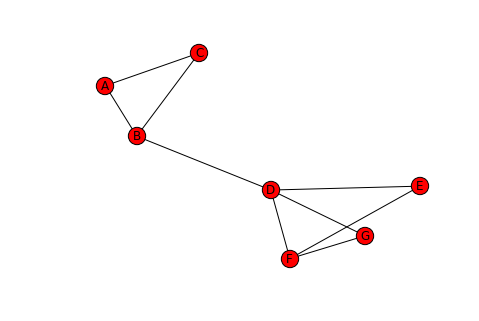

In [34]:
import networkx as nx
%matplotlib inline
def create_example_graph():
    graph = nx.Graph()
    graph.add_edges_from([('A', 'B'), ('A', 'C'), ('B', 'C'),
                          ('B', 'D'), ('D', 'E'), ('D', 'F'),
                          ('D', 'G'), ('E', 'F'), ('G', 'F')])
    return graph

graph = create_example_graph()
nx.draw(graph, with_labels=True)

In [35]:
# We'll use networkx's built-in betweenness computation in this example.
nx.edge_betweenness_centrality(graph)

{('A', 'B'): 0.23809523809523808,
 ('A', 'C'): 0.047619047619047616,
 ('B', 'D'): 0.5714285714285714,
 ('C', 'B'): 0.23809523809523808,
 ('D', 'F'): 0.19047619047619047,
 ('D', 'G'): 0.21428571428571427,
 ('E', 'D'): 0.21428571428571427,
 ('E', 'F'): 0.07142857142857142,
 ('G', 'F'): 0.07142857142857142}

In [48]:
def girvan_newman(G, depth=0):
    """ Recursive implementation of the girvan_newman algorithm.
    See http://www-rohan.sdsu.edu/~gawron/python_for_ss/course_core/book_draft/Social_Networks/Networkx.html
    
    Args:
    G.....a networkx graph

    Returns:
    A list of all discovered communities."""

    if G.order() == 1:
        return [G.nodes()]
    
    def find_best_edge(G0):
        eb = nx.edge_betweenness_centrality(G0)
        # eb is dict of (edge, score) pairs, where higher is better
        # Return the edge with the highest score.
        return sorted(eb.items(), key=lambda x: x[1], reverse=True)[0][0]

    # Each component is a separate community. We cluster each of these.
    components = [c for c in nx.connected_component_subgraphs(G)]
    indent = '   ' * depth  # for printing
    while len(components) == 1:
        edge_to_remove = find_best_edge(G)
        print indent + 'removing', edge_to_remove
        G.remove_edge(*edge_to_remove)
        components = [c for c in nx.connected_component_subgraphs(G)]

    result = [c.nodes() for c in components]
    print  indent + 'components=', result
    for c in components:
        result.extend(girvan_newman(c, depth + 1))

    return result

In [49]:
result = girvan_newman(create_example_graph())

removing ('B', 'D')
components= [['A', 'C', 'B'], ['E', 'D', 'G', 'F']]
   removing ('C', 'B')
   removing ('A', 'B')
   components= [['A', 'C'], ['B']]
      removing ('A', 'C')
      components= [['A'], ['C']]
   removing ('E', 'F')
   removing ('E', 'D')
   components= [['E'], ['D', 'G', 'F']]
      removing ('G', 'F')
      removing ('D', 'G')
      components= [['D', 'F'], ['G']]
         removing ('D', 'F')
         components= [['D'], ['F']]
